# Imports and configuration

In [ ]:
import numpy as np

import os 
import matplotlib.pyplot as plt
import sys
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf 
physical_devices = tf.config.experimental.list_physical_devices()
for device in physical_devices:
    if device.device_type == 'GPU':
        print('Running with GPU', device.name)
        tf.config.experimental.set_memory_growth(device, True)
tf.keras.utils.set_random_seed(1111)
tf.config.experimental.enable_op_determinism()

sys.path.append("../")
import models
import nn
from DataGen import DataGen


In [7]:
# Save path
path = "./ibvp2d"
csv_path = os.path.join(path, "errors.csv")

# Main program

In [ ]:
pod_dim_range = 2**np.arange(8)
errors = dict()
errors['N'] = pod_dim_range

for i in range(len(pod_dim_range)):
    
    # Model hyperparameters
    n_params = 2
    latent_dim = 5
    pod_dim = int(pod_dim_range[i])
    alpha_train = 0.9
    n_epochs = 500
    lr = 3e-3
    batch_size = 10
    n_early_stopping = 250
    N_t = 20

    # Loading data from files
    parent_dir_files =  os.path.join('..', 'data_appx', 'ibvp2d')
    filenames = dict()
    filenames['params'] = os.path.join(parent_dir_files, 'params_train_600.mat')
    filenames['target'] = os.path.join(parent_dir_files, 'S_U_train_600.mat')
    filenames_test = dict()
    filenames_test['params'] = os.path.join(parent_dir_files, 'params_test.mat')
    filenames_test['target'] = os.path.join(parent_dir_files, 'S_U_test.mat')
    data_gen = DataGen(pod_dim = pod_dim, alpha_train = alpha_train, rpod = True)
    data_gen.read(filenames, filenames_test, transpose = True, N_t = N_t)


    # Define POD-DL-ROM components
    reduced_network = nn.DenseNetwork(
        width = 10, 
        depth = 3, 
        output_dim = latent_dim
    )
    encoder_network = nn.DenseNetwork(
        width = 25, 
        depth = 5, 
        output_dim = latent_dim
    )
    decoder_network = nn.DenseNetwork(
        width = 25, 
        depth = 5, 
        output_dim = pod_dim
    )

    # Assemble POD-DL-ROM architecture
    architecture = dict()
    architecture['reduced_network'] = reduced_network
    architecture['encoder_network'] = encoder_network
    architecture['decoder_network'] = decoder_network
    poddlrom_model_train, poddlrom_model_test = nn.create_dlrom(
        n_inputs = n_params,
        architecture = architecture
    )

    # Instantiate the model
    poddlrom = models.PODNetwork(
        data_gen = data_gen,
        model_train = poddlrom_model_train,
        model_test = poddlrom_model_test,
        save_folder = 'ibvp2d',
        name = 'net' + str(i)
    )

    # Train, load or test model
    print('\n------------------> N = %d <------------------' % pod_dim)
    poddlrom.compile(lr = lr, n_early_stopping = n_early_stopping)
    poddlrom.fit(batch_size = batch_size, n_epochs = n_epochs, verbose = 0)
    poddlrom.load()
    err_dict = poddlrom.test()
    
    # Update errors collection
    if i == 0:
        for key in err_dict.keys():
            errors[key] = list()
    for key in err_dict.keys():
            errors[key].append(err_dict[key])
    


# Save csv

In [4]:
# Convert to dataframe
errors_df = pd.DataFrame.from_dict(errors)

# Save csv file with errors
if not os.path.exists(path):
    os.makedirs(path)
csv_path = os.path.join(path, "errors.csv")
errors_df.to_csv(csv_path) 

# Load csv and visualize

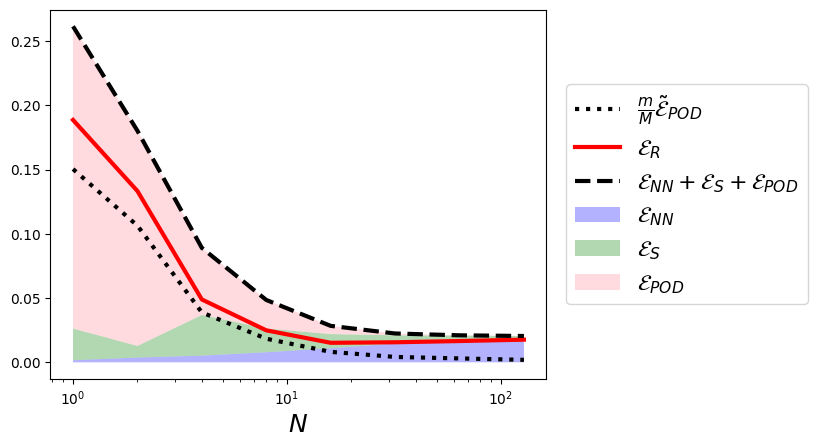

In [9]:
# Load csv
errors_df = pd.read_csv(csv_path)

# Plot
plt.semilogx(errors_df['N'], errors_df['lower_bound'], 
             'k:', linewidth = 3, label = r'$\frac{m}{M} \tilde{\mathcal{E}}_{POD}$')
plt.semilogx(errors_df['N'], errors_df['E_R'],
             'r-', linewidth = 3, label = '$\mathcal{E}_R$')
plt.semilogx(errors_df['N'], errors_df['upper_bound'],
             'k--', linewidth = 3, label = '$\mathcal{E}_{NN} + \mathcal{E}_S + \mathcal{E}_{POD}$')
plt.fill_between(errors_df['N'].to_numpy(), errors_df['E_NN'].to_numpy(), 0, color = 'b', alpha = 0.3,
                 label = '$\mathcal{E}_{NN}$', edgecolor = None)
plt.fill_between(errors_df['N'].to_numpy(), errors_df['E_S'].to_numpy() + errors_df['E_NN'].to_numpy(), errors_df['E_NN'].to_numpy(),
                 color = 'g', alpha = 0.3, label = '$\mathcal{E}_{S}$', edgecolor = None)
plt.fill_between(errors_df['N'].to_numpy(), errors_df['E_S'].to_numpy() + errors_df['E_NN'].to_numpy() + errors_df['E_POD'].to_numpy(),
                 errors_df['E_NN'].to_numpy() + errors_df['E_S'].to_numpy(), color = 'lightpink', alpha = 0.5,
                 label = '$\mathcal{E}_{POD}$', edgecolor = None)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc = "center left", borderaxespad = 0, fontsize = 16)
plt.xlabel('$N$', fontsize = 18)
plt.show()